---
# **Ecuacion diferencial ordinaria con condición de frontera**

David Felipe Bambague (dbambague@unal.edu.co)

Carlos Andrés del Valle (cdelv@unal.edu.co)

---

 Vamos a resolver la ecuación difrerncial que da cuenta de las oscilaciones de una viga con extremo fijo y extremo libre.

  \begin{equation*}
      y^{\prime\prime} -4y =0
  \end{equation*}

  Las condiciones de frontera del problema son:

  \begin{equation*}
      y(0)=0\\
      y(1)=5\\
  \end{equation*}

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
dde.config.real.set_float64()

Using backend: tensorflow.compat.v1

2022-10-21 12:26:56.870103: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-21 12:26:56.873713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 12:26:56.873728: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2022-10-21 12:26:58.033435: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-21 12:26:58.033467: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


## **1. Definir la Ecuación a Resolver**

In [2]:
def ode(x,y):
    dy_dx = dde.grad.jacobian(y,x)
    d2y_dx2 = dde.grad.hessian(y,x)
    return  d2y_dx2 - 4*y
  

## **2. Definir Dominio de la Ecuación**

In [3]:
geom = dde.geometry.TimeDomain(0, 1)

## **3. Definir Condiciones de Frontera**

In [4]:
IC1 = dde.icbc.IC(geom, lambda x: 0, lambda x, on_initial: np.isclose(x[0], 0))
IC2 = dde.icbc.IC(geom, lambda x: 5, lambda x, on_initial: np.isclose(x[0], 1))

## **4. Crear Datos de Entrenamiento**

In [5]:
def func(x):
    return 10*np.exp(2)*np.sinh(2*x)/(np.exp(4)-1)

data = dde.data.PDE(geom, ode, [IC1,IC2], 14, 4, solution=func, num_test=100)

## **5. Crear la Red Neuronal**

In [6]:
layer_size = [1] + [20]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

## **6. Compilar y Entrenar el Modelo**

In [7]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.033299 s



/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-21 12:26:59.365460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.234965 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.62e-01, 0.00e+00, 2.67e+01]    [2.52e-01, 0.00e+00, 2.67e+01]    [1.04e+00]    


2022-10-21 12:26:59.573084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


1000      [1.89e-03, 7.48e-06, 5.53e-06]    [3.04e-03, 7.48e-06, 5.53e-06]    [7.47e-04]    
2000      [6.05e-04, 1.41e-06, 8.41e-07]    [1.11e-03, 1.41e-06, 8.41e-07]    [3.00e-04]    
3000      [1.87e-03, 4.48e-05, 7.70e-05]    [1.76e-03, 4.48e-05, 7.70e-05]    [3.42e-03]    
4000      [2.67e-04, 3.27e-06, 1.94e-05]    [4.16e-04, 3.27e-06, 1.94e-05]    [1.27e-03]    
5000      [1.24e-03, 1.83e-05, 3.62e-05]    [1.28e-03, 1.83e-05, 3.62e-05]    [2.37e-03]    
6000      [1.64e-03, 5.90e-05, 1.03e-04]    [1.43e-03, 5.90e-05, 1.03e-04]    [3.74e-03]    
7000      [5.48e-05, 2.21e-09, 4.52e-09]    [9.73e-05, 2.21e-09, 4.52e-09]    [2.72e-05]    
8000      [4.92e-05, 5.05e-09, 3.09e-09]    [8.24e-05, 5.05e-09, 3.09e-09]    [2.98e-05]    
9000      [4.41e-05, 8.18e-09, 2.66e-09]    [7.14e-05, 8.18e-09, 2.66e-09]    [3.24e-05]    
10000     [3.96e-05, 1.27e-08, 2.79e-09]    [6.24e-05, 1.27e-08, 2.79e-09]    [3.57e-05]    

Best model at step 10000:
  train loss: 3.96e-05
  test loss: 6.25e-0

## **7. Graficar Solucion**

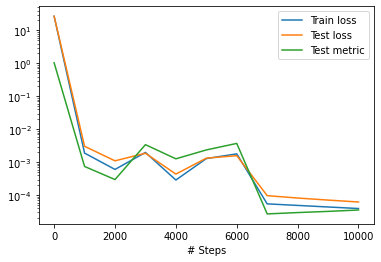

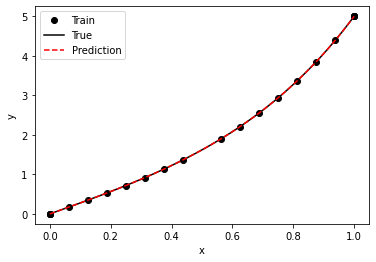

In [8]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)
